# Exploring Glacier Data Sets at NSIDC 

## Learning Objectives 
* Awareness of glacier data sets from the NASA MEaSUREs (Making Earth System Data Records for Use in Research Environments) program that are archived at the NSIDC DAAC (National Snow and Ice Data Center Distributed Active Archive Center). 
* Set up spatial and temporal filters programmatically
* Programmatically access and download velocity and DEM GeoTIFFs 
* Extract corner coordinates of velocity GeoTIFF and use these to spatially subset the DEM tile
* Downsample subsetted DEM so it has the same spatial resolution as the velocity file
* Overlay the velocity GeoTIFF on the spatially subsetted and downsampled DEM file. 

## Data Sets
This tutorial demonstrates how to access, download and visualize the following two glacier data sets available from NSIDC DAAC:

* [MEaSUREs Greenland Ice Mapping Project (GIMP) Digital Elevation Model from GeoEye and WorldView Imagery, Version 1](https://nsidc.org/data/nsidc-0715)

* [MEaSUREs Greenland Ice Velocity: Selected Glacier Site Velocity Maps from InSAR, Version 3](https://nsidc.org/data/nsidc-0481)



## 1. Load necessary python libraries and modules 
Run the cell below to import all the libraries and modules that are needed for this notebook. 

In [1]:
import requests
import getpass
import socket 
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import re
import time
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping, box
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth
import numpy as np
import rasterio
from rasterio.mask import mask
from affine import Affine 
import pycrs
from osgeo import gdal 

ModuleNotFoundError: No module named 'pycrs'

## 2. Input Earthdata Login credentials
An Earthdata Login account is required to access data from the NSIDC DAAC. If you do not already have an Earthdata Login account, visit http://urs.earthdata.nasa.gov to register. 

Once you have account, run the cells below to input your login credentials and email address associated with it. 

In [2]:
uid = input('Earthdata Login user name: ') # Enter Earthdata Login user name

Earthdata Login user name:  jroebuck


In [3]:
pswd = getpass.getpass('Earthdata Login password: ') # Enter Earthdata Login password

Earthdata Login password:  ··········


In [4]:
email = input('Email address associated with Earthdata Login account: ') # Enter Earthdata login email

Email address associated with Earthdata Login account:  jennifer.roebuck@colorado.edu


## 3. Determine the data set IDs for the data sets that you would like to download
Each data set at NSIDC has a data set ID associated with it. You can determine the data set ID from the data set landing page. It is given in grey in the top right corner of the page, as highlighted by the red rectangle in the example image below:

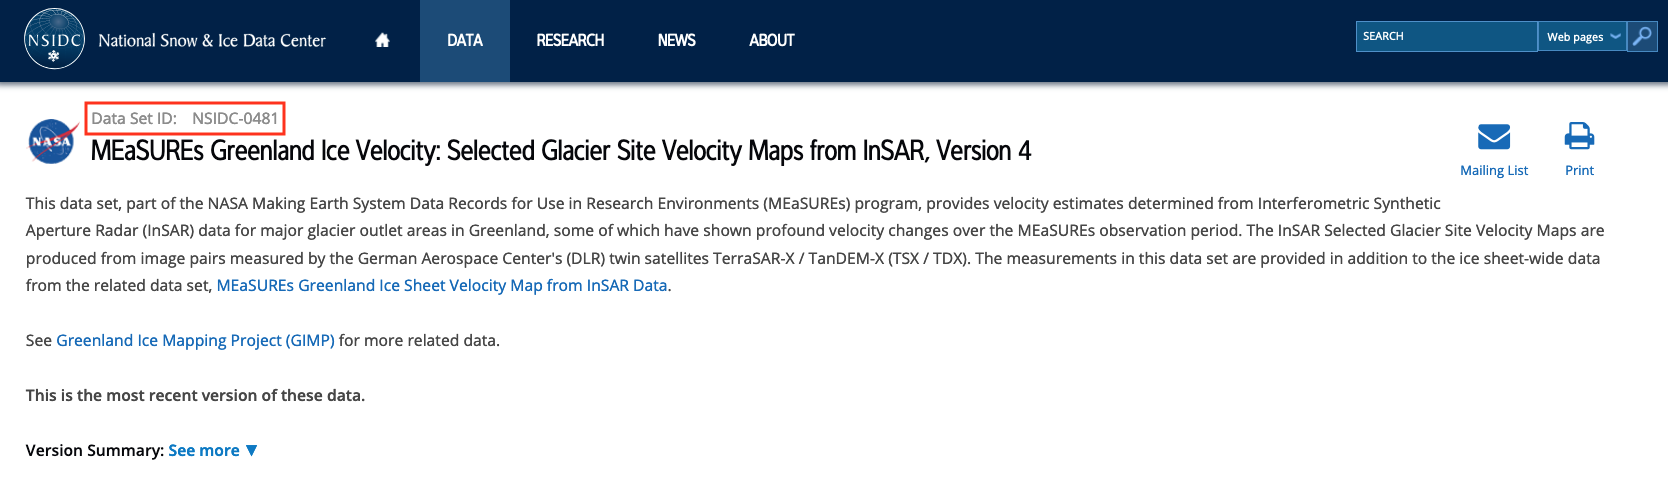

We will focus on two glacier data sets here and we have listed their data set IDs next to them:

* DEM - [NSIDC-0715](https://nsidc.org/data/nsidc-0715)
* Glacier velocities from SAR data - [NSIDC-0481](https://nsidc.org/data/nsidc-0481)

Run the cell below to assign the data set IDs to variables. 

In [5]:
sndem = 'NSIDC-0715' # DEM
snvel = 'NSIDC-0481' # glacier velocities from SAR data

## 4. Set up spatial filter
You can define the spatial filter with a shapefile or any other vector-based spatial data format. If you already have a file you would like to use, then make sure it is in the same directory you are running this notebook in and change the filename in the first line in the cell below. 

Alternatively, you can create your own json file by going to a data set landing page for one of the data sets e.g. [DEM](https://nsidc.org/data/nsidc-0715) and drawing a polygon around the area you would like to find data for and then exporting it as a json file, see the image below for more details.


<div>
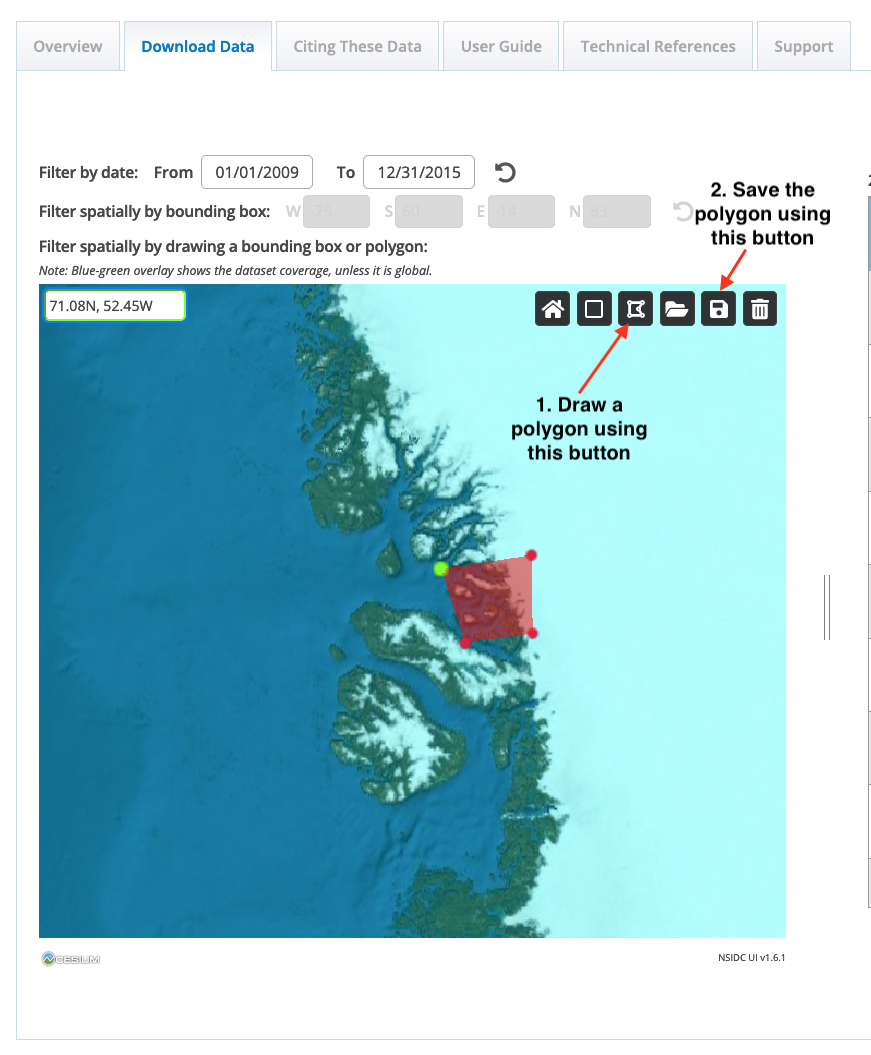
</div>

As an example we will focus on the Jakobshavn Isbrae glacier and have already drawn and downloaded a json file for it.

Run the cell below to read in the file and it will output the polygon coordinates that will be used in the data search. 

Polygon coordinates to be used in search: -33.56728911182825,68.32169789833897,-31.656753728193948,68.2379324426868,-31.427077095331903,69.08600748777394,-33.33248765576581,69.18055520428652,-33.56728911182825,68.32169789833897


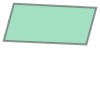

In [6]:
polygon_filepath = str(os.getcwd() + '/nordfjord_polygon.json') # Note: A shapefile or other vector-based spatial data format could be substituted here.

gdf = gpd.read_file(polygon_filepath) #Return a GeoDataFrame object

# Simplify polygon for complex shapes in order to pass a reasonable request length to CMR. The larger the tolerance value, the more simplified the polygon.
# Orient counter-clockwise: CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.
poly = orient(gdf.simplify(0.05, preserve_topology=False).loc[0],sign=1.0)

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
print('Polygon coordinates to be used in search:', polygon)
poly

## 5. Set up individual temporal filters for each data set 
Each of the data sets have different temporal ranges, so you need to set a different temporal range for each one:

* NSIDC-0715 - Use the temporal range of 01/12/2015-31/12/2015 if you wish to download just the 'fit' and 'reg' best data tiles. The 'fit' version of the DEM is a smoothed single DEM that provides a best continuous surface for visual display and applications based on slope information. If you want to evaluate pixel elevation changes then use the 'reg' DEM, which is also available as a quarterly time series and adjust the temporal range in the cell below if you wish to download the quarterly time series DEMs. 

* NSIDC-0481 - Feel free to adjust this temporal range in the cell below, this is just an example. 

In [7]:
temporaldem = '2015-12-01T00:00:00Z,2015-12-31T23:59:59Z' # temporal range for the DEM (NSIDC-0715)
temporalvel = '2017-01-01T00:00:00Z,2017-12-31T23:59:59Z' # temporal range for the SAR velocity images (NSIDC-0481)


## 6. Download DEM data
### 6.1 Determine the latest version number 
Run the cell below to determine the latest version number for the DEM data set, this is needed to ensure you download the most up to date version of the data. 

In [8]:

version_params = {
    'short_name': sndem
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=version_params)
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', sndem, ' is ', latest_version)

The most recent version of  NSIDC-0715  is  1


### 6.2 Determine how many DEM tiles exist over time and area of interest, 
Run the cell below to determine how many DEM tiles are available for the spatial area and temporal range that we specificed in the cells above. 

In more detail, we will use the granule_info function to query metadata about the DEM data set and associated files using the [Common Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html), which is a high-performance, high-quality, continuously evolving metadata system that catalogs Earth Science data and associated service metadata records. Note that not all NSIDC data can be searched at the file level using CMR, particularly those outside of the NASA DAAC program.

In [9]:
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
headers={'Accept': 'application/json'}

#search for dem granules 
search_params_dem = {
    'short_name': sndem,
    'version': latest_version,
    'temporal': temporaldem,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }
while True:
    response = requests.get(granule_search_url, params=search_params_dem, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params_dem['page_num'] += 1
    
print('There are', len(granules), 'granules of', sndem, 'version', latest_version, 'over my area and time of interest.')


There are 2 granules of NSIDC-0715 version 1 over my area and time of interest.


### 6.3 Determine the average size of the granules and their total volume
Run the cell below to determine the average size of the granules and the total volume, this is just to give you an idea of the size of the files you will be downloading.

In [10]:
granule_sizes = [float(granule['granule_size']) for granule in granules]

print(f'The average size of each granule is {mean(granule_sizes):.2f} MB and the total size of all {len(granules)} granules is {sum(granule_sizes):.2f} MB')


The average size of each granule is 331.00 MB and the total size of all 2 granules is 662.00 MB


### 6.4 Create the API endpoint to download the DEM data
This uses all the information/variables established previously to create an API endpoint that can be used to download the DEM data. Run the cell below to create the API endpoint.

In [11]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

#Set the request mode to asynchronous if the number of granules is over 100, otherwise synchronous is enabled by default
if len(granules) > 100:
    request_mode = 'async'
    page_size = 2000
else: 
    page_size = 100
    request_mode = 'stream'

#Determine number of orders needed for requests over 2000 granules. 
page_num = math.ceil(len(granules)/page_size)

print('There will be', page_num, 'total order(s) processed for our', sndem, 'request.')

param_dict = {'short_name': sndem, 
              'version': latest_version, 
              'temporal': temporaldem, 
              'time': '', 
              'polygon': polygon,
              'Boundingshape': '', 
              'format': '', 
              'projection': '', 
              'projection_parameters': '', 
              'Coverage': '', 
              'page_size': page_size, 
              'request_mode': request_mode, 
              'agent': 'NO', 
              'email': email, }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

#Print API base URL + request parameters
endpoint_list = [] 
for i in range(page_num):
    page_val = i + 1
    API_request = api_request = f'{base_url}?{param_string}&page_num={page_val}'
    endpoint_list.append(API_request)

print(*endpoint_list, sep = "\n") 

There will be 1 total order(s) processed for our NSIDC-0715 request.
https://n5eil02u.ecs.nsidc.org/egi/request?short_name=NSIDC-0715&version=1&temporal=2015-12-01T00:00:00Z,2015-12-31T23:59:59Z&polygon=-33.56728911182825,68.32169789833897,-31.656753728193948,68.2379324426868,-31.427077095331903,69.08600748777394,-33.33248765576581,69.18055520428652,-33.56728911182825,68.32169789833897&page_size=100&request_mode=stream&agent=NO&email=jennifer.roebuck@colorado.edu&page_num=1


### 6.5 Request and download DEM data
Run the cell below to download the DEM data using the python requests library, and it will put them in an 'Outputs' folder, which will be automatically created if it does not already exist.

In [12]:
# Create an output folder if the folder does not already exist.

path = str(os.getcwd() + '/Outputs_demo')
if not os.path.exists(path):
    os.mkdir(path)

    
# Create session to store cookie and pass credentials to capabilities url

session = requests.session()

# Different access methods depending on request mode:

if request_mode=='async':
    # Request data service for each page number, and unzip outputs
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)

    # For all requests other than spatial file upload, use get function
        request = session.get(base_url, params=param_dict)

        print('Request HTTP response: ', request.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request.raise_for_status()
        print('Order request URL: ', request.url)
        esir_root = ET.fromstring(request.content)
        print('Order request response XML content: ', request.content)

    #Look up order ID
        orderlist = []   
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)

    #Create status URL
        statusURL = base_url + '/' + orderID
        print('status URL: ', statusURL)

    #Find order status
        request_response = session.get(statusURL)    
        print('HTTP response from order response URL: ', request_response.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request_response.raise_for_status()
        request_root = ET.fromstring(request_response.content)
        statuslist = []
        for status in request_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Data request ', page_val, ' is submitting...')
        print('Initial request status is ', status)

    #Continue loop while request is still processing
        while status == 'pending' or status == 'processing': 
            print('Status is not complete. Trying again.')
            time.sleep(10)
            loop_response = session.get(statusURL)

    # Raise bad request: Loop will stop for bad response code.
            loop_response.raise_for_status()
            loop_root = ET.fromstring(loop_response.content)

    #find status
            statuslist = []
            for status in loop_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Retry request status is: ', status)
            if status == 'pending' or status == 'processing':
                continue

    #Order can either complete, complete_with_errors, or fail:
    # Provide complete_with_errors error message:
        if status == 'complete_with_errors' or status == 'failed':
            messagelist = []
            for message in loop_root.findall("./processInfo/"):
                messagelist.append(message.text)
            print('error messages:')
            pprint.pprint(messagelist)

    # Download zipped order if status is complete or complete_with_errors
        if status == 'complete' or status == 'complete_with_errors':
            downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
            print('Zip download URL: ', downloadURL)
            print('Beginning download of zipped output...')
            zip_response = session.get(downloadURL)
            # Raise bad request: Loop will stop for bad response code.
            zip_response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
                z.extractall(path)
            print('Data request', page_val, 'is complete.')
        else: print('Request failed.')
            
else:
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)
        print('Requesting...')
        request = session.get(base_url, params=param_dict)
        print('HTTP response from order response URL: ', request.status_code)
        request.raise_for_status()
        d = request.headers['content-disposition']
        fname = re.findall('filename=(.+)', d)
        dirname = os.path.join(path,fname[0].strip('\"'))
        print('Downloading...')
        open(dirname, 'wb').write(request.content)
        print('Data request', page_val, 'is complete.')
    
    # Unzip outputs
    for z in os.listdir(path): 
        if z.endswith('.zip'): 
            zip_name = path + "/" + z 
            zip_ref = zipfile.ZipFile(zip_name) 
            zip_ref.extractall(path) 
            zip_ref.close() 
            os.remove(zip_name) 


Order:  1
Requesting...
HTTP response from order response URL:  200
Downloading...
Data request 1 is complete.


## 7 Velocity data 
We will follow the same few steps as above, except this time we downloading the velocity data
### 7.1 Determine the latest version number 
Run the cell below to determine the latest version number for the velocity data set, this is needed to ensure you download the most up to date version of the data. 

In [13]:
version_params = {
    'short_name': snvel
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=version_params)
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', snvel, ' is ', latest_version)

The most recent version of  NSIDC-0481  is  4


### 7.2 Determine how many files exist over the specified time and area 
Run the cell below to determine how many velocity files are available for the spatial area and temporal range that we specificed in the cells above. 

In [14]:
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
headers={'Accept': 'application/json'}

#search for dem granules 
search_params_dem = {
    'short_name': snvel,
    'version': latest_version,
    'temporal': temporalvel,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }
while True:
    response = requests.get(granule_search_url, params=search_params_dem, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params_dem['page_num'] += 1
    
print('There are', len(granules), 'granules of', snvel, 'version', latest_version, 'over my area and time of interest.')


There are 20 granules of NSIDC-0481 version 4 over my area and time of interest.


### 7.3 Determine the average size of the granules and their total volume
Run the cell below to determine the average size of the granules and the total volume, this is just to give you an idea of the size of the files you will be downloading.

In [15]:
granule_sizes = [float(granule['granule_size']) for granule in granules]

print(f'The average size of each granule is {mean(granule_sizes):.2f} MB and the total size of all {len(granules)} granules is {sum(granule_sizes):.2f} MB')


The average size of each granule is 3.85 MB and the total size of all 20 granules is 76.91 MB


### 7.4 Create the API endpoint to download the velocity data 
This uses all the information/variables established previously to create an API endpoint that can be used to download the velocity data. Run the cell below to create the API endpoint.

In [16]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

#Set the request mode to asynchronous if the number of granules is over 100, otherwise synchronous is enabled by default
if len(granules) > 100:
    request_mode = 'async'
    page_size = 2000
else: 
    page_size = 100
    request_mode = 'stream'

#Determine number of orders needed for requests over 2000 granules. 
page_num = math.ceil(len(granules)/page_size)

print('There will be', page_num, 'total order(s) processed for our', snvel, 'request.')

param_dict = {'short_name': snvel, 
              'version': 3, 
              'temporal': temporalvel, 
              'time': '', 
              'polygon': polygon,
              'Boundingshape': '', 
              'format': '', 
              'projection': '', 
              'projection_parameters': '', 
              'Coverage': '', 
              'page_size': page_size, 
              'request_mode': request_mode, 
              'agent': 'NO', 
              'email': email, }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

#Print API base URL + request parameters
endpoint_list = [] 
for i in range(page_num):
    page_val = i + 1
    API_request = api_request = f'{base_url}?{param_string}&page_num={page_val}'
    endpoint_list.append(API_request)

print(*endpoint_list, sep = "\n") 

There will be 1 total order(s) processed for our NSIDC-0481 request.
https://n5eil02u.ecs.nsidc.org/egi/request?short_name=NSIDC-0481&version=3&temporal=2017-01-01T00:00:00Z,2017-12-31T23:59:59Z&polygon=-33.56728911182825,68.32169789833897,-31.656753728193948,68.2379324426868,-31.427077095331903,69.08600748777394,-33.33248765576581,69.18055520428652,-33.56728911182825,68.32169789833897&page_size=100&request_mode=stream&agent=NO&email=jennifer.roebuck@colorado.edu&page_num=1


### 7.5 Request and download the velocity data
Run the cell below to download the velocity data using the python requests library, and it will put them in the 'Outputs' folder.

In [17]:
#path = str(os.getcwd() + '/Outputs_v3')

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()

# Different access methods depending on request mode:

if request_mode=='async':
    # Request data service for each page number, and unzip outputs
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)

    # For all requests other than spatial file upload, use get function
        request = session.get(base_url, params=param_dict)

        print('Request HTTP response: ', request.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request.raise_for_status()
        print('Order request URL: ', request.url)
        esir_root = ET.fromstring(request.content)
        print('Order request response XML content: ', request.content)

    #Look up order ID
        orderlist = []   
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)

    #Create status URL
        statusURL = base_url + '/' + orderID
        print('status URL: ', statusURL)

    #Find order status
        request_response = session.get(statusURL)    
        print('HTTP response from order response URL: ', request_response.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request_response.raise_for_status()
        request_root = ET.fromstring(request_response.content)
        statuslist = []
        for status in request_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Data request ', page_val, ' is submitting...')
        print('Initial request status is ', status)

    #Continue loop while request is still processing
        while status == 'pending' or status == 'processing': 
            print('Status is not complete. Trying again.')
            time.sleep(10)
            loop_response = session.get(statusURL)

    # Raise bad request: Loop will stop for bad response code.
            loop_response.raise_for_status()
            loop_root = ET.fromstring(loop_response.content)

    #find status
            statuslist = []
            for status in loop_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Retry request status is: ', status)
            if status == 'pending' or status == 'processing':
                continue

    #Order can either complete, complete_with_errors, or fail:
    # Provide complete_with_errors error message:
        if status == 'complete_with_errors' or status == 'failed':
            messagelist = []
            for message in loop_root.findall("./processInfo/"):
                messagelist.append(message.text)
            print('error messages:')
            pprint.pprint(messagelist)

    # Download zipped order if status is complete or complete_with_errors
        if status == 'complete' or status == 'complete_with_errors':
            downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
            print('Zip download URL: ', downloadURL)
            print('Beginning download of zipped output...')
            zip_response = session.get(downloadURL)
            # Raise bad request: Loop will stop for bad response code.
            zip_response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
                z.extractall(path)
            print('Data request', page_val, 'is complete.')
        else: print('Request failed.')
            
else:
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)
        print('Requesting...')
        request = session.get(base_url, params=param_dict)
        print('HTTP response from order response URL: ', request.status_code)
        request.raise_for_status()
        d = request.headers['content-disposition']
        fname = re.findall('filename=(.+)', d)
        dirname = os.path.join(path,fname[0].strip('\"'))
        print('Downloading...')
        open(dirname, 'wb').write(request.content)
        print('Data request', page_val, 'is complete.')
    
    # Unzip outputs
    for z in os.listdir(path): 
        if z.endswith('.zip'): 
            zip_name = path + "/" + z 
            zip_ref = zipfile.ZipFile(zip_name) 
            zip_ref.extractall(path) 
            zip_ref.close() 
            os.remove(zip_name) 


Order:  1
Requesting...
HTTP response from order response URL:  200
Downloading...
Data request 1 is complete.


## 8. Clean up the Outputs folder
Run the cell below to clean up the Outputs folder and remove all the order directories. This will make it easier to find and view the files. 

In [18]:
# Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))    

## 9. List all the downloaded files 
Run the cell below to list all the DEM and velocity files that were downloaded. This list is needed for the next step.

In [19]:
dir_list = os.listdir(path)

print('Files in ', path)

#print(dir_list)

for x in dir_list:
    if x.endswith('.tif'):
        print(x)

Files in  /Users/jero7025/Documents/data_tutorials/Glacier_Notebook/Outputs_v5
TSX_E68.80N_14Nov17_25Nov17_19-41-25_ey_v03.0.tif
TSX_E68.80N_01Feb17_12Feb17_19-41-14_vy_v03.0.tif
TSX_E68.80N_30Dec16_21Jan17_19-41-16_vv_v03.0.tif
TSX_E68.80N_22May17_02Jun17_19-41-18_vx_v03.0.tif
TSX_E68.80N_24Jun17_05Jul17_19-41-19_vv_v03.0.tif
TSX_E68.80N_30Apr17_11May17_19-41-17_ey_v03.0.tif
TSX_E68.80N_23Oct17_14Nov17_19-41-25_vy_v03.0.tif
TSX_E68.80N_27Jul17_07Aug17_19-41-21_ey_v03.0.tif
TSX_E68.80N_30Apr17_11May17_19-41-17_vy_v03.0.tif
TSX_E68.80N_23Oct17_14Nov17_19-41-25_ey_v03.0.tif
TSX_E68.80N_27Jul17_07Aug17_19-41-21_vy_v03.0.tif
TSX_E68.80N_14Nov17_25Nov17_19-41-25_vy_v03.0.tif
TSX_E68.80N_01Feb17_12Feb17_19-41-14_ey_v03.0.tif
TSX_E68.80N_22May17_02Jun17_19-41-18_ex_v03.0.tif
TSX_E68.80N_18Aug17_29Aug17_19-41-22_vv_v03.0.tif
TSX_E68.80N_07Aug17_18Aug17_19-41-22_vy_v03.0.tif
TSX_E68.80N_01Oct17_12Oct17_19-41-24_ex_v03.0.tif
TSX_E68.80N_05Jul17_16Jul17_19-41-20_vv_v03.0.tif
TSX_E68.80N_16Jul17_2

## 10. Plot/visualize the data we have downloaded 
### 10.1 Select and read in a DEM tile and a velocity file 
Based on the list of filenames above, find the filenames of the DEM tile and velocity file you wish to plot, and input these filenames into the cell below. 

In the example below we will use the 'fit' version of the DEM tile, which provides the best continuous surface for visual display. The velocity file is the velocity magnitude (vv). We will need to spatially subset the DEM to the velocity file bounds, so need to set a filename for the spatially subset DEM. 

Run the cell below to open the files and assign them to variables.

In [20]:
#Read in the velocity file
#fp = str(path + '/TSX_W68.60N_22Jul17_13Aug17_10-14-44_vv_v03.0.tif')
fp = str(path + '/TSX_E68.80N_07Aug17_18Aug17_19-41-22_vv_v03.0.tif')
data = rasterio.open(fp)

#Read in the DEM file
fp2 = str(path + '/tile_4_2_fit_30m_hillshade_v01.1.tif')
dem = rasterio.open(fp2)

#Name of output file to save the spatially subset DEM
dem_clp = str(path + '/clipped_tile_4_2.tif')

### 10.2 Clip DEM based on spatial extent of the velocity data
The DEM tiles cover a much larger area than the each of the velocity files, therefore to focus on the velocity data, we can spatially subset the DEM using the spatial extent of the velocity data. 

Run the cell below to determine the spatial extent of the velocity file, and use these coordinates to spatially subset the DEM tile. 

In [21]:
# Create a bounding box based on the extents of the velocity file
extent = data.bounds
bbox = box(extent[0], extent[1], extent[2], extent[3])

#Insert this bounding box into a GeoDataFrame
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(3413))

#Reproject into the same coordinate system as the raster data
geo = geo.to_crs('epsg:3413')

#Need the coordinates of the geometry in the right format for rasterio
# Can do this by creating and using the following function
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# Get the geometry coordinates by using the above function
coords = getFeatures(geo)

#print(coords)

# Now use these coords to clip the DEM
out_img, out_transform = mask(dataset=dem, shapes=coords, crop=True)

/Users/jero7025/opt/anaconda3/envs/glacier/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### 10.3 Save the spatially subset DEM 
Run the cell below to save the spatially subset DEM as a new GeoTIFF, with metadata that inludes the correct projection information. This makes it easier to use and plot later on. 

In [22]:
#Now need to modify the metadata so we can save it in the new file, so first need to copy
# the metadata from the original file
out_meta = dem.meta.copy()

#Uncomment the line below if you wish to print out the metadata
#print(out_meta)  

# Now need to parse the EPSG value from the CRS so we can create a Proj4 string using PyCRS
epsg_code = int(data.crs.data['init'][5:])

#Uncomment the line below if you wish to print out the EPSG code
#print(epsg_code)

# Now need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text)
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                          )


# Save the clipped raster DEM as a new geotiff
with rasterio.open(dem_clp, 'w', **out_meta) as dest:
    dest.write(out_img)

#close the original DEM file
dem.close()

### 10.4 Resample the subset DEM using GDAL
In order to plot the velocity and DEM data they both need to have the same spatial resolution. The subsetted DEM has a spatial resolution of 30m, the velocity data has a spatial resolution of 100m. 

Run the cell below to downsample the DEM data so it has the same spatial resolution as the velocity data 

In [23]:
dem_sr = str(path + '/subset_dem.tif')
kwargs = {'format': 'GTiff', 'xRes': 100, 'yRes': 100}
ds = gdal.Translate(dem_sr, dem_clp, **kwargs)
ds = None

### 10.5 Set up the grids to plot the DEM and velocity data 
To plot the spatially subset and downsampled DEM with the velocity data, we need to set up a grid. Run the cell below to set up the grid, and it will also print out the metadata information for each of the GeoTIFFs. 

In [24]:
# read in subsetted and resampled DEM
src = rasterio.open(dem_sr)

# print out metadata information
for k in src.meta:
    print(k,src.meta[k])

# Retrieve the affine transformation
if isinstance(src.transform, Affine):
     transform = src.transform
else:
     transform = src.affine

N = src.width
M = src.height
dx = transform.a
dy = transform.e
minx = transform.c
maxy = transform.f

# Read the image data, flip upside down if necessary
data_in = src.read(1)
if dy < 0:
    dy = -dy
    data_in = np.flip(data_in, 0)

#Uncomment the line below if you wish to see the min/max DEM values
#print('Data minimum, maximum = ', np.amin(data_in), np.amax(data_in))

# Generate X and Y grid locations
xdata = minx + dx/2 + dx*np.arange(N)
ydata = maxy - dy/2 - dy*np.arange(M-1,-1,-1)

extent2 = [xdata[0], xdata[-1], ydata[0], ydata[-1]]

### read in the velocity data
for k in data.meta:
    print(k,data.meta[k])

# Retrieve the affine transformation
if isinstance(data.transform, Affine):
     transform = data.transform
else:
     transform = data.affine

N2 = data.width
M2 = data.height
dx2 = transform.a
dy2 = transform.e
minx2 = transform.c
maxy2 = transform.f

# Read the image data, flip upside down if necessary
vel_in = data.read(1)
if dy2 < 0:
    dy2 = -dy2
    vel_in = np.flip(vel_in, 0)

#Uncomment the line below if you wish to see the min/max velocity values
#print('Data minimum, maximum = ', np.amin(vel_in), np.amax(vel_in))

# Generate X and Y grid locations
xdata2 = minx2 + dx2/2 + dx2*np.arange(N2)
ydata2 = maxy2 - dy2/2 - dy2*np.arange(M2-1,-1,-1)

extent3 = [xdata2[0], xdata2[-1], ydata2[0], ydata2[-1]]

#Need to mask the no data values in the velocity data
vel_masked = np.ma.masked_where(vel_in == -1.0, vel_in, copy=True)

driver GTiff
dtype uint8
nodata 0.0
width 818
height 905
count 1
crs PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["unknown",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]
transform | 100.00, 0.00, 435230.00|
| 0.00,-100.00,-2228630.00|
| 0.00, 0.00, 1.00|
driver GTiff
dtype float32
nodata -1.0
width 818
height 905
count 1
crs EPSG:3413
transform | 100.00, 0.00, 435250.00|
| 0.00,-100.00,-2228650.00|
| 0.00, 0.00, 1.00|


### 10.6 Plot the DEM and the velocity data
This next cell will plot the spatially subsetted and downsampled DEM with the velocity on top. The velocity is also slightly transparent so you can see the DEM underneath. There is also an option to save this figure as a .png, uncomment the last line if you wish to save the image. 

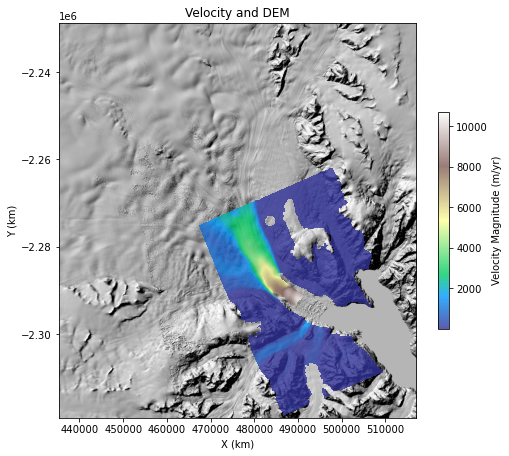

In [25]:
%matplotlib inline
plt.figure(figsize=(8,8))
fig = plt.imshow(data_in, extent=extent2, origin='lower', cmap='gray')
fig2 = plt.imshow(vel_masked, extent=extent3, origin='lower', cmap='terrain', alpha=0.8)
plt.title('Velocity and DEM')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
cb = plt.colorbar(fig2, shrink=0.5)
cb.set_label('Velocity Magnitude (m/yr)')

#Option to save the figure
#plt.savefig("velocity.png", dpi=300, bbox_inches='tight', pad_inches=0.5)
